# Standard imports

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import HpAlgorithms
import HpMLUtils
import HpMLPlots
import HpHyperParameterOptimisation
import HpTrainingFrame

In [2]:
region='ge6jge4b'
invertTestTrain=False

In [3]:
df_mc=pd.read_hdf('/eos/user/j/jglatzer/L2Output_R20_Nov_v2_pandaspython3/pandas_INC_'+region+'.h5', 'INC_'+region)

# Prepare data for parameterised H+ classification

split into test and training data

In [4]:
htf=HpTrainingFrame.HpTrainingFrame(df_mc)
X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass="multi",addMass=True)
if invertTestTrain:
    X_tmp=X_train
    y_tmp=y_train
    w_tmp=w_train
    X_train=X_test
    y_train=y_test
    w_train=w_test
    X_test=X_tmp
    y_test=y_tmp
    w_test=w_tmp
print(X_train.columns, X_train.shape)

Index(['nJets', 'nBTags_70', 'pT_jet1', 'Mbb_MindR_70', 'pT_jet5', 'H1_all',
       'dRbb_avg_70', 'dRlepbb_MindR_70', 'Muu_MindR_70', 'HT_jets',
       'Mbb_MaxPt_70', 'Mbb_MaxM_70', 'Mjjj_MaxPt', 'Centrality_all',
       'hpmass'],
      dtype='object') (235995, 15)


In [5]:
HpMLUtils.summarizeFitData(X_train, y_train,w_train, categories=X_train.hpmass, showavevarminmax=False)

X.shape= (235995, 15) y.shape= (235995,)w.shape= (235995,)
columns= Index(['nJets', 'nBTags_70', 'pT_jet1', 'Mbb_MindR_70', 'pT_jet5', 'H1_all',
       'dRbb_avg_70', 'dRlepbb_MindR_70', 'Muu_MindR_70', 'HT_jets',
       'Mbb_MaxPt_70', 'Mbb_MaxM_70', 'Mjjj_MaxPt', 'Centrality_all',
       'hpmass'],
      dtype='object')
categories= [-1, 200, 225, 250, 275, 300, 350, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000]

sum of weights per category
       all 2627.7878701014624
        -1 1773.191898437017
       200 103.25055362269731
       225 139.41190725846945
       250 140.77163076529942
       275 127.89850805160341
       300 111.59172096685447
       350 84.23831982536186
       400 64.2254739452055
       500 35.552147119629055
       600 20.4739117537052
       700 11.982341892420514
       800 6.982210934992669
       900 4.238406393684132
      1000 2.4718073416139097
      1200 0.9239538781114109
      1400 0.3568699933922498
      1600 0.14095859103517255
 

ok the columns include the H+ mass now

Now on to scaling the weights to have a flat distributiong in H+ mass

In [6]:
sb=HpMLUtils.MultiSBWeightsScaler(backgroundclass=-1)
sb.fit(X_train,X_train.hpmass, sample_weight=w_train)
X_train=sb.transform(X_train,X_train.hpmass, sample_weight=w_train)
w_train.groupby(X_train.hpmass).sum()

hpmass
-1       0.500000
 200     0.006536
 225     0.006536
 250     0.006536
 275     0.006536
 300     0.009804
 350     0.013072
 400     0.019608
 500     0.026144
 600     0.026144
 700     0.026144
 800     0.026144
 900     0.026144
 1000    0.039216
 1200    0.052288
 1400    0.052288
 1600    0.052288
 1800    0.052288
 2000    0.052288
Name: weight, dtype: float64

now set the hpmass for the background correctly (same PDF as signal)

In [7]:
from scipy.stats import rv_discrete

signalsum=w_train[X_train.hpmass>0].sum()
xk=[]
pk=[]
for name, group in w_train.groupby(X_train.hpmass):
    if name>0:
        xk.append((-1)*name)
        pk.append(group.sum()/signalsum)
#print xk,pk
custm=rv_discrete(values=(xk,pk))
#print "before resetting hpmass", sorted(X_train.hpmass.unique())
X_train["hpmass"]=X_train.hpmass.apply(lambda x: x if x>0 else custm.rvs())
#print "resetting hpmass", sorted(X_train.hpmass.unique())

print("the following is the difference between + and - mass")
print((w_train*((X_train.hpmass>0)-0.5)*2).groupby(X_train.hpmass.abs()).sum())
print("the following is the sum of weights")
print(w_train.groupby(X_train.hpmass).sum())

X_train.hpmass=X_train.hpmass.abs()

the following is the difference between + and - mass
hpmass
200     0.000210
225     0.000255
250     0.000058
275     0.000702
300     0.000058
350    -0.000480
400     0.001557
500    -0.002798
600    -0.000879
700    -0.002415
800     0.001256
900     0.000767
1000    0.002668
1200   -0.000543
1400   -0.000896
1600    0.001750
1800   -0.000470
2000   -0.000800
dtype: float64
the following is the sum of weights
hpmass
-2000    0.053087
-1800    0.052757
-1600    0.050538
-1400    0.053184
-1200    0.052830
-1000    0.036548
-900     0.025377
-800     0.024888
-700     0.028559
-600     0.027022
-500     0.028942
-400     0.018051
-350     0.013552
-300     0.009746
-275     0.005833
-250     0.006478
-225     0.006281
-200     0.006326
 200     0.006536
 225     0.006536
 250     0.006536
 275     0.006536
 300     0.009804
 350     0.013072
 400     0.019608
 500     0.026144
 600     0.026144
 700     0.026144
 800     0.026144
 900     0.026144
 1000    0.039216
 1200    0.052288


## Training the classifier

In [8]:
clf=HpAlgorithms.getGradientBDTClassifier(options = {'n_estimators': 200, 'learning_rate': 0.1}) #let's get away from the default trees to get a better performance

let's have a quick look if those parameters are roughly ok for mH+=800 GeV

In [9]:
def prepareTestDS(hpmass,X_test,y_test,w_test):
    mask=(X_test.hpmass==hpmass) | (X_test.hpmass<=0)
    X_new=X_test.copy()
    X_new["hpmass"]=hpmass
    return X_new[mask], y_test[mask], w_test[mask]
print(sorted(X_test.hpmass.unique()))

[-1, 200, 225, 250, 275, 300, 350, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000]


Training for  200
Saving plot as  validationcurve_GradientBoostingClassifier_massparBDTval_n_estimators_criterionfriedman_mse_initNone_learning_rate01_lossdeviance_max_depth5_max_featuresNone_max_leaf_nodesNone_min_impurity_decrease00_min_impurity_splitNone_min_samples_leaf1_min_samples_split2_min_weight_fraction_leaf001_n_estimators200_n_iter_no_changeNone_presortauto_random_state0_subsample10_tol00001_validation_fraction01_verbose0_warm_startFalse.png


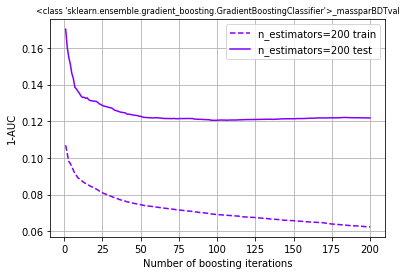

In [10]:
X_test800,y_test800,w_test800=prepareTestDS(800,X_test,y_test,w_test)
opt=HpHyperParameterOptimisation.HpOptimise("massparBDTval",clf,X_train,y_train,w_train,X_test800,y_test800,w_test800)
opt.saveValidationCurve(variable="n_estimators")

Training for  120
Saving plot as  validationcurve_GradientBoostingClassifier_massparBDTval_n_estimators_criterionfriedman_mse_initNone_learning_rate013_lossdeviance_max_depth5_max_featuresNone_max_leaf_nodesNone_min_impurity_decrease00_min_impurity_splitNone_min_samples_leaf1_min_samples_split2_min_weight_fraction_leaf001_n_estimators120_n_iter_no_changeNone_presortauto_random_state0_subsample10_tol00001_validation_fraction01_verbose0_warm_startFalse.png


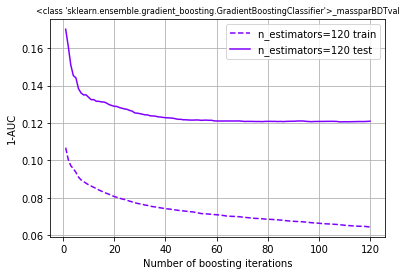

In [11]:
clf=HpAlgorithms.getGradientBDTClassifier(options = {'n_estimators': 120, 'learning_rate': 0.13}) #let's get away from the default trees to get a better performance
X_test800,y_test800,w_test800=prepareTestDS(800,X_test,y_test,w_test)
opt=HpHyperParameterOptimisation.HpOptimise("massparBDTval",clf,X_train,y_train,w_train,X_test800,y_test800,w_test800)
opt.saveValidationCurve(variable="n_estimators")

In [12]:
%time clf.fit(X_train, y_train, sample_weight=w_train)

CPU times: user 1min 24s, sys: 16.9 ms, total: 1min 24s
Wall time: 1min 24s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.13, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.01, n_estimators=120,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [13]:
from joblib import dump
if invertTestTrain:
    dump(clf, 'models/massparameterisedBDT_'+region+'_train2mod1.joblib') 
else:
    dump(clf, 'models/massparameterisedBDT_'+region+'_train2mod0.joblib') 

This is pretty fast now....

## Evaluating the classifier for all H+ masses

In [14]:
hpmasses=[200,225,250,275,300,350,400,500,600,700,800,900,1000,1200,1400,1600,1800,2000]

In [15]:
print("1-ROC AUC for different masses in 6j4b - test, train")

trainvalues=[]
testvalues=[]
X_testfilter={}
y_testfilter={}
w_testfilter={}
X_trainfilter={}
y_trainfilter={}
w_trainfilter={}

for hpmass in hpmasses:
    X_trainfilter[hpmass], X_testfilter[hpmass], _, y_trainfilter[hpmass], y_testfilter[hpmass],_, w_trainfilter[hpmass], w_testfilter[hpmass], _=htf.prepare(hpmass=hpmass,addMass=True)
    X_trainfilter[hpmass].hpmass=hpmass
    X_testfilter[hpmass].hpmass=hpmass
  
    opt=HpHyperParameterOptimisation.HpOptimise("massparBDT"+str(hpmass),clf,X_trainfilter[hpmass],y_trainfilter[hpmass],w_trainfilter[hpmass],X_testfilter[hpmass],y_testfilter[hpmass],w_testfilter[hpmass])
    test,train=opt.test(X_trainfilter[hpmass], y_trainfilter[hpmass], w_trainfilter[hpmass], X_testfilter[hpmass], y_testfilter[hpmass], w_testfilter[hpmass])
    trainvalues.append(train)
    testvalues.append(test)

    print(hpmass, test, train)

1-ROC AUC for different masses in 6j4b - test, train
200 0.39865348086727326 0.37647496215996745
225 0.37993954683337017 0.3547941510733934
250 0.37545354433720335 0.3451755204911705
275 0.3656864723679112 0.3396676244766883
300 0.3543584021357806 0.3314291192891935
350 0.33364414116284624 0.31007715109012846
400 0.3093389676683632 0.27381434372399804
500 0.2413833433050332 0.22136666882310663
600 0.19300293355452303 0.1757817044222949
700 0.1523664354076426 0.13345258056450782
800 0.12098438167833292 0.10494137161851547
900 0.09453910322093728 0.08544668586431903
1000 0.08029144436220359 0.06807678915960591
1200 0.05140655973752983 0.042363112843126105
1400 0.03686222033356912 0.029393986094943036
1600 0.026668588901687884 0.021322319396123723
1800 0.020894009928167034 0.014860049951214371
2000 0.015325097782351693 0.011995006309926115


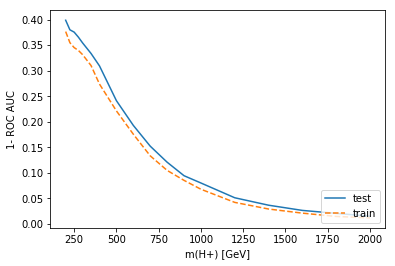

In [16]:
plt.plot(hpmasses, testvalues, '-', label='test')
plt.plot(hpmasses, trainvalues, '--', label='train')
plt.xlabel('m(H+) [GeV]')
plt.ylabel('1- ROC AUC')
plt.legend(loc="lower right")

There is basically no overtraining --> we can probably win a bit of sensitivity by moving towards a higher number of trees and more depth or lower learning rate

## Optimising the hyperparameters for m(H+)=800 GeV
and hoping it holds independently

In [17]:
X_test800,y_test800,w_test800=prepareTestDS(800,X_test,y_test,w_test)

Validation curve for learning_rate
Training for  0.05
Training for  0.1
Training for  0.13
Training for  0.2
Training for  0.5
Saving plot as  validationcurve_GradientBoostingClassifier_massparBDT800_learning_rate_criterionfriedman_mse_initNone_learning_rate05_lossdeviance_max_depth5_max_featuresNone_max_leaf_nodesNone_min_impurity_decrease00_min_impurity_splitNone_min_samples_leaf1_min_samples_split2_min_weight_fraction_leaf001_n_estimators120_n_iter_no_changeNone_presortauto_random_state0_subsample10_tol00001_validation_fraction01_verbose0_warm_startFalse.png
Validation curve for max_depth
Training for  3
Training for  4
Training for  5
Training for  6
Saving plot as  validationcurve_GradientBoostingClassifier_massparBDT800_max_depth_criterionfriedman_mse_initNone_learning_rate05_lossdeviance_max_depth6_max_featuresNone_max_leaf_nodesNone_min_impurity_decrease00_min_impurity_splitNone_min_samples_leaf1_min_samples_split2_min_weight_fraction_leaf001_n_estimators120_n_iter_no_changeNon

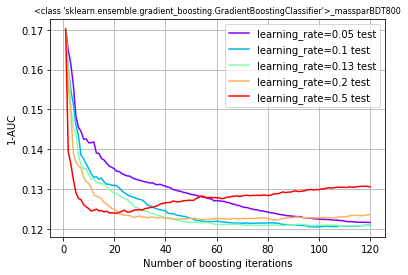

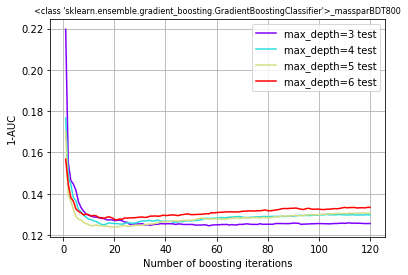

In [18]:
hpopt=HpHyperParameterOptimisation.HpOptimise("massparBDT800",clf,X_train,y_train,w_train,X_test800,y_test800,w_test800)
hpopt.saveAllValidationCurves()

## Training the classifier at N-1 masses and checking at the remaining mass

In [19]:
from scipy.stats import rv_discrete
sb=HpMLUtils.MultiSBWeightsScaler(backgroundclass=-1)

trainvalues_cross=[]
testvalues_cross=[]
for hpmass in hpmasses:
    X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass=hpmass, addMass=True, invertsignal=True)
    sb.fit(X_train,X_train.hpmass, sample_weight=w_train)
    X_train=sb.transform(X_train,X_train.hpmass, sample_weight=w_train)

    signalsum=w_train[X_train.hpmass>0].sum()
    xk=[]
    pk=[]
    for name, group in w_train.groupby(X_train.hpmass):
        if name>0:
            xk.append((-1)*name)
            pk.append(group.sum()/signalsum)
    
    custm=rv_discrete(values=(xk,pk))
    X_train["hpmass"]=X_train.hpmass.apply(lambda x: x if x>0 else custm.rvs())
    X_train.hpmass=X_train.hpmass.abs()
    
    clf=HpAlgorithms.getGradientBDTClassifier()
    clf.fit(X_train, y_train, sample_weight=w_train)
    #write the results into a file
    if invertTestTrain:
        dump(clf, 'models/massparameterisedBDT_allbut'+str(hpmass)+'_'+region+'_train2mod1.joblib') 
    else:
        dump(clf, 'models/massparameterisedBDT_allbut'+str(hpmass)+'_'+region+'_train2mod0.joblib') 
    
    X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval =htf.prepare(hpmass=hpmass, addMass=True, invertsignal=False)
    
    #X_testfilter[hpmass],y_testfilter[hpmass],w_testfilter[hpmass]=prepareTestDS(hpmass,X_test,y_test,w_test)
    X_test["hpmass"]=hpmass
    X_train["hpmass"]=hpmass
    opt=HpHyperParameterOptimisation.HpOptimise("massparBDT"+str(hpmass),clf,X_train,y_train,w_train,X_test,y_test,w_test)
    test,train=opt.test(X_train, y_train, w_train, X_test, y_test, w_test)
    trainvalues_cross.append(train)
    testvalues_cross.append(test)
    print(hpmass, test, train)

200 0.4341472641262535 0.4123583542667082
225 0.402309835696098 0.3706594860383263
250 0.39151284670985265 0.3550819401792946
275 0.37132152374140426 0.34522468745477497
300 0.36250946054014066 0.3325550578903561
350 0.34873392001956116 0.31994596314928936
400 0.3161712735204151 0.2857722166847537
500 0.25728463621301845 0.23722449005350166
600 0.19851636481167678 0.18172982223020306
700 0.15699241273497677 0.13933053491244507
800 0.12535052792432722 0.11089341035777578
900 0.09680493090178843 0.0873937902692421
1000 0.08161626267462285 0.06969176599605009
1200 0.05236659244903363 0.042444435322117835
1400 0.037888194149682364 0.03007445784665408
1600 0.027484866644260197 0.021981847964485435
1800 0.02161010354367865 0.014898939789839138
2000 0.01728961720973088 0.013362295741044972


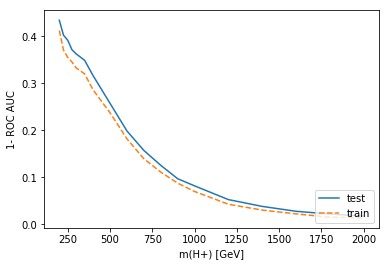

In [20]:
plt.plot(hpmasses, testvalues_cross, '-', label='test')
plt.plot(hpmasses, trainvalues_cross, '--', label='train')
plt.xlabel('m(H+) [GeV]')
plt.ylabel('1- ROC AUC')
plt.legend(loc="lower right")
plt.show()

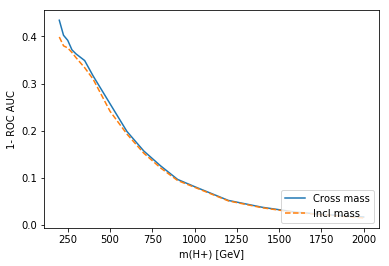

In [21]:
plt.plot(hpmasses, testvalues_cross, '-', label='Cross mass')
plt.plot(hpmasses, testvalues, '--', label='Incl mass')
plt.xlabel('m(H+) [GeV]')
plt.ylabel('1- ROC AUC')
plt.legend(loc="lower right")
plt.show()

--> It seems that leaving out one mass point in between almost makes no difference (exception: 200 GeV, but that's not really a surprise)

### let's see how this compares to the default BDT

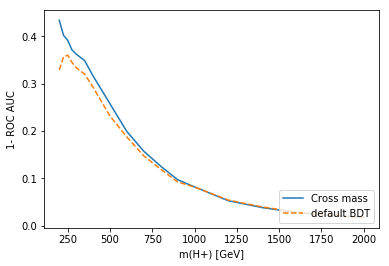

In [22]:
testdefaultBDT=[0.3290841140322679, 0.3566890794845421, 0.3602662115193581, 0.34498428916467183, 0.33375748714257425, 0.32019286312547357, 0.29225728165594855, 0.23146437865390979, 0.18697956512088676, 0.14718158177504637, 0.11895855659790655, 0.09204235231427149, 0.08130798049109356, 0.05375180442290828, 0.039379786382951254, 0.028362194212484093, 0.022254177247589824, 0.0160571366514084]
plt.plot(hpmasses, testvalues_cross, '-', label='Cross mass')
plt.plot(hpmasses, testdefaultBDT, '--', label='default BDT')
plt.xlabel('m(H+) [GeV]')
plt.ylabel('1- ROC AUC')
plt.legend(loc="lower right")
plt.show()

and how about cross section limit

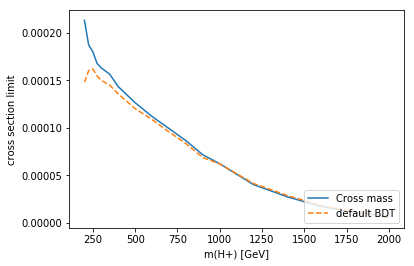

No handles with labels found to put in legend.


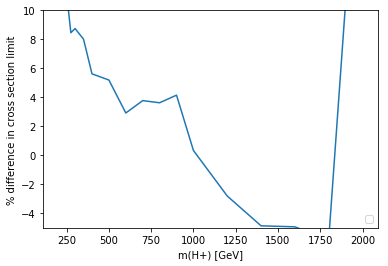

In [23]:
z=[ 5.84983620e-03, -4.16702246e-03,  1.22938606e-03, -1.36789294e-05] #fit values for ROC AUC to cross section limit comparison
f=np.poly1d(z)
plt.plot(hpmasses, f(testvalues_cross), '-', label='Cross mass')
plt.plot(hpmasses, f(testdefaultBDT), '--', label='default BDT')
plt.xlabel('m(H+) [GeV]')
plt.ylabel('cross section limit')
plt.legend(loc="lower right")
plt.show()

#and not %difference
plt.plot(hpmasses, (f(testvalues_cross)/f(testdefaultBDT)-1)*100, '-')
#plt.plot(hpmasses, f(testdefaultBDT), '--', label='default BDT')
plt.xlabel('m(H+) [GeV]')
plt.ylabel('% difference in cross section limit')
plt.legend(loc="lower right")
plt.ylim((-5,10))
plt.show()


one problem with the BDT is probably that the BDT score per event is not exactly smooth (probably quite ok as the distribution should be pretty smooth)

In [24]:
def decisionfunction(eventnumber):
    testmasses=np.linspace(200,2000, 1801)
    line1=X_test.iloc[eventnumber].copy()
    df = pd.DataFrame([line1]*len(testmasses))
    df["hpmass"]=testmasses
    y_pred=clf.decision_function(df)
    y_pred[:5]
    plt.plot(testmasses, y_pred, '-')
    plt.xlabel('m(H+) [GeV]')
    plt.ylabel('BDT score')
    #plt.legend(loc="lower right")
    plt.show()

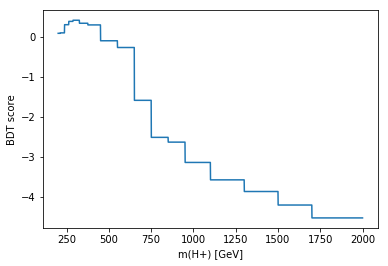

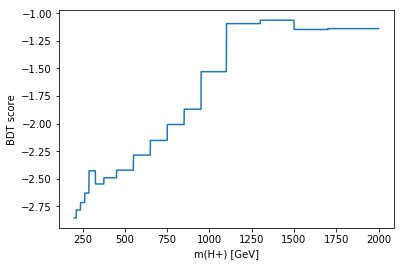

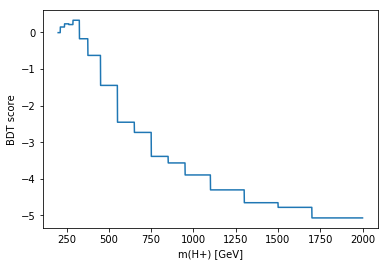

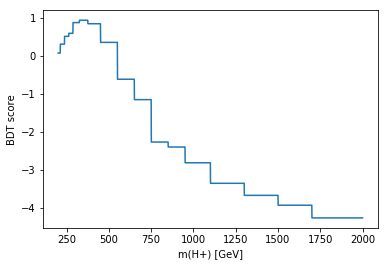

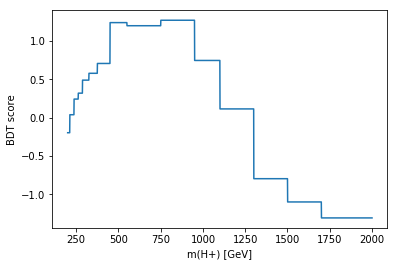

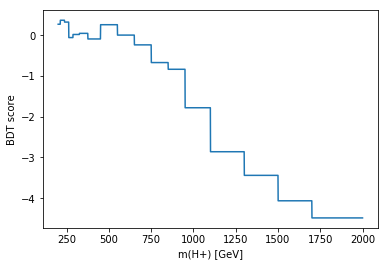

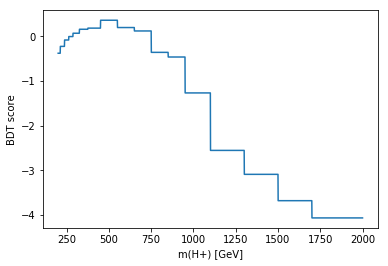

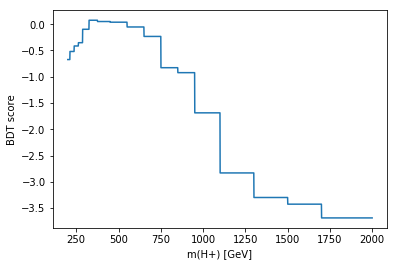

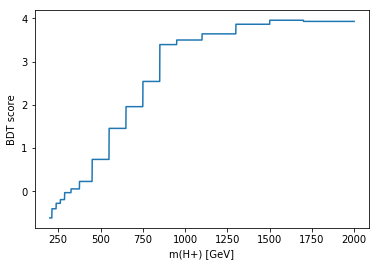

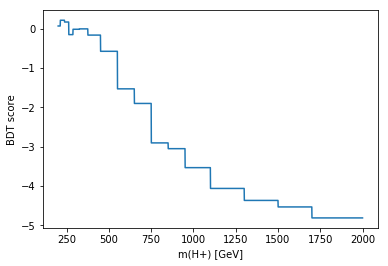

In [25]:
for i in range(0,10):
    decisionfunction(i)